https://docs.ray.io/en/master/_modules/ray/tune/tuner.html

In [6]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import air, tune
from ray.tune.schedulers import ASHAScheduler

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [8]:

# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE = 512
TEST_SIZE = 256

def train(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [9]:
def train_mnist(config):
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST("~/data", train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)

        # Send the current training result back to Tune
        tune.report(mean_accuracy=acc)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")

In [10]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9),
}

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.MNIST("~/data", train=True, download=True)

tuner = tune.Tuner(
    train_mnist,
    param_space=search_space,
)
results = tuner.fit()

Result for train_mnist_b65ee_00000:
  date: 2022-09-01_21-50-38
  done: false
  experiment_id: a236309f5b29428cb5a28df0e7322a92
  hostname: DESKTOP-UV2VLMG
  iterations_since_restore: 1
  mean_accuracy: 0.6
  node_ip: 127.0.0.1
  pid: 17148
  time_since_restore: 4.868346452713013
  time_this_iter_s: 4.868346452713013
  time_total_s: 4.868346452713013
  timestamp: 1662065438
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b65ee_00000
  warmup_time: 0.007287263870239258
  
Result for train_mnist_b65ee_00000:
  date: 2022-09-01_21-50-41
  done: true
  experiment_id: a236309f5b29428cb5a28df0e7322a92
  experiment_tag: 0_lr=0.0693,momentum=0.6635
  hostname: DESKTOP-UV2VLMG
  iterations_since_restore: 10
  mean_accuracy: 0.909375
  node_ip: 127.0.0.1
  pid: 17148
  time_since_restore: 7.423003911972046
  time_this_iter_s: 0.28441572189331055
  time_total_s: 7.423003911972046
  timestamp: 1662065441
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b65ee_00000

2022-09-01 21:50:41,556	INFO tune.py:758 -- Total run time: 12.61 seconds (12.45 seconds for the tuning loop).


[<AxesSubplot:>]

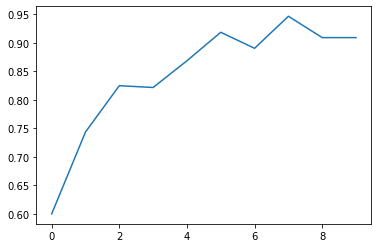

In [11]:
dfs = {result.log_dir: result.metrics_dataframe for result in results}
[d.mean_accuracy.plot() for d in dfs.values()]